# Importation des images et des librairies

<ipython-input-1-95b420effec2>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load("coco_sample.pth")


torch.Size([9, 3, 520, 520])


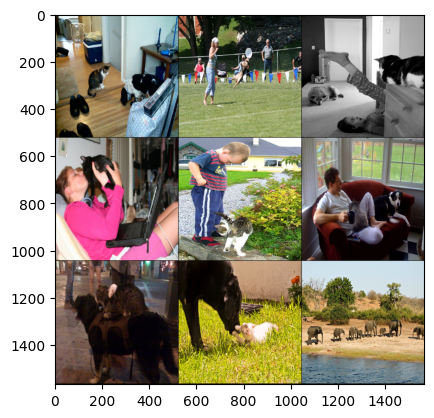

In [1]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt

if not os.path.isfile("coco_sample.pth"):
  os.system("wget https://httpmail.onera.fr/21/050a4e5c4611d260c1b8035b5dc8617eO1A12h/coco_sample.pth")

img = torch.load("coco_sample.pth")
print(img.shape)

visu = torchvision.utils.make_grid(img,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

# Prise en main segmentation

les 9 images étant chargées, on peut leur appliquer un modèle deeplab pré-appris comme
torchvision.models.segmentation.DeepLabV3_ResNet50_Weights

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 85.8MB/s]


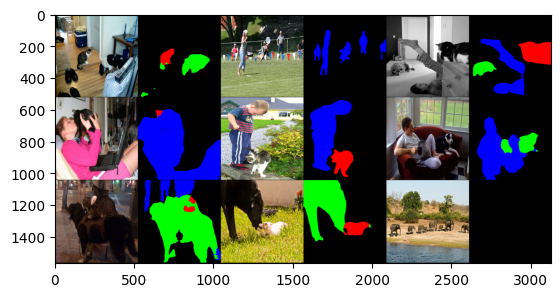

In [ ]:
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval()

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

with torch.no_grad():
  x = normalize(img)
  z = net(x)["out"] # on prédit des cartes de score de confiance
  z = z[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,z = z.max(1) # on prend le meilleur score

# visualisation des prédictions : il faut transformer les indices de classes en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (z==1).float() # red for cat
pred[:,1,:,:] = (z==2).float() # green for dog
pred[:,2,:,:] = (z==3).float() # blue for person

visu = torch.cat([img,pred],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

Le résultat est loin d'être parfait mais on voit que le réseau est "fonctionnel" (il s'agit d'un backbone resnet - au fait beaucoup mieux aujourd'hui mais il faut aller chercher les modèles ailleurs...).

On peut en tester un autre plus rapide (et moins bon) comme torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights:

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 85.7MB/s]


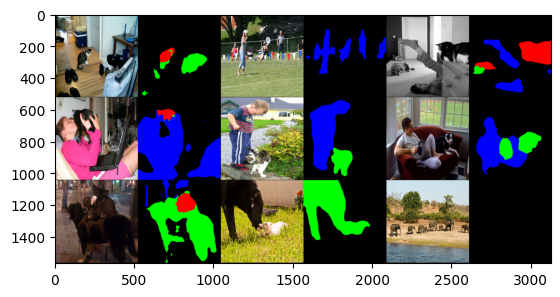

In [ ]:
W = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).eval()

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

with torch.no_grad():
  x = normalize(img)
  z = net(x)["out"] # on prédit des cartes de score de confiance
  z = z[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,z = z.max(1) # on prend le meilleur score

# visualisation des prédictions : il faut transformer les indices de classes en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (z==1).float() # red for cat
pred[:,1,:,:] = (z==2).float() # green for dog
pred[:,2,:,:] = (z==3).float() # blue for person

visu = torch.cat([img,pred],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

# Implémentation de l'attaque untargeted


Le but est d'adapter la méthode d'attaque décrite dans le fichier "TP_ADVERSAIRE.ipynb" pour notre algorithme de segmentation.

On commence par le deuxième réseau essayé ci-dessus (torchvision.models.segmentationdeeplabv3_mobilenet_v3_large).

On doit d'abord choisir le réseau et récupérer les prédictions initiales du réseau.

In [ ]:
W = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).eval()

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

with torch.no_grad():
  x = normalize(img)
  outputs = net(x)["out"] # on prédit des cartes de score de confiance
  outputs = outputs[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,outputs = outputs.max(1) # on prend le meilleur score

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 135MB/s]


On vient ensuite mettre en place l'attaque puis l'optimiser.

In [ ]:
####### Mise en place de l'attaque #######
cefunction = torch.nn.CrossEntropyLoss()            # Fonction de perte, par exemple CrossEntropyLoss
attaque = torch.nn.Parameter(torch.zeros(x.shape))  # Créer la perturbation, initialement nulle
optimizer = torch.optim.SGD([attaque],lr=0.005)     # Optimiseur pour ajuster la perturbation

# Paramètres de l'attaque
epsilon = 10 / 255  # Amplitude maximale de la perturbation
num_steps = 10      # Nombre d'itérations

####### Optimisation de l'attaque #######
for i in range(num_steps):
  # Calculer les prédictions avec perturbation
  attacked_input = normalize(img + attaque)
  attacked_outputs = net(attacked_input)["out"]

  # Calculer la cross entropy et l'afficher
  # La cross entropy est la mesure qui dit à quel point les deux arguments sont différents
  ce = cefunction(attacked_outputs, outputs)
  print(i,float(ce))

  # Calculer les gradients par rapport à la perturbation
  ce = -ce              # On veut Maximiser la cross entropy car on veut que le resultat perturbé soit le plus loin possible des résultats normaux
  optimizer.zero_grad()
  ce.backward()
  attaque.grad = attaque.grad.sign() # Gradient signé
  optimizer.step()

  # Mettre à jour la perturbation
  with torch.no_grad():
    attaque = torch.clamp(attaque, -epsilon, epsilon) # Limiter la perturbation
    attaque = torch.clamp(img + attaque, 0, 1) - img  # Contrainte d'image valide

  # Optimisation de l'attaque
  attaque = torch.nn.Parameter(attaque.clone())
  optimizer = torch.optim.SGD([attaque],lr=0.005)

####### Récupérer les résultats de l'attaque #######
# Appliquer la perturbation à l'image originale
perturbed_img = img + attaque

# Prédictions après attaque
with torch.no_grad():
    attacked_outputs = net(normalize(perturbed_img))["out"]
    attacked_outputs = attacked_outputs[:, [0, 8, 12, 15], :, :]
    _, attacked_outputs = attacked_outputs.max(1)

0 2.4145760536193848
1 4.222280502319336
2 5.3444366455078125
3 6.05645751953125
4 7.185595989227295
5 8.211139678955078
6 8.965034484863281
7 9.2427978515625
8 9.835305213928223
9 10.817317008972168


On peut finalement visualiser les résultats : On affiche sur le premier graphique les images originales (à gauche) et les images attaquées (à droite), et sur le deuxième graphique les prédictions originales (à gauche) et les prédictions attaquées (à droite).

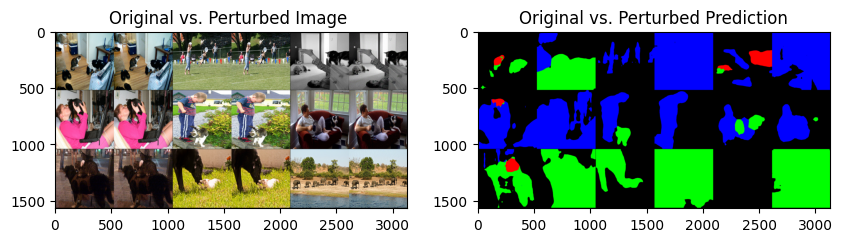

In [ ]:
# Visualisation des images à côté des images perturbées
plt.figure(figsize=(10, 5))
plt.subplot(1,  2, 1)
plt.title("Original vs. Perturbed Image ")
visu = torch.cat([img,perturbed_img],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())


# Visualisation des prédictions et des prédictions perturbées
plt.subplot(1, 2, 2)
plt.title("Original vs. Perturbed Prediction")
# Création de la prediction originale en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (outputs==1).float() # red for cat
pred[:,1,:,:] = (outputs==2).float() # green for dog
pred[:,2,:,:] = (outputs==3).float() # blue for person
# Création de la prediction perturbée en couleur
pred_pert = torch.zeros(9,3,520,520)
pred_pert[:,0,:,:] = (attacked_outputs==1).float() # red for cat
pred_pert[:,1,:,:] = (attacked_outputs==2).float() # green for dog
pred_pert[:,2,:,:] = (attacked_outputs==3).float() # blue for person
# Affichage
visu = torch.cat([pred,pred_pert],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())

plt.show()

On remarque donc que l'attaque a marché : d'un côté, on ne peux pas différencier à l'oeil nu l'image perturbée de l'image originale ; de l'autre côté, les perturbations ont réussi à rendre les prédictions bien plus mauvaises.

# Implémentation d'une attaque targeted

Le but ici n'est plus de simplement rendre le réseau moins efficace, mais d'essayer de le tromper en lui faisant croire à une classe à la place d'une autre.
Par exemple, on pourrait essayer d'entrainer l'attaque pour que le réseau détecte plus la classe chien ou la classe background.

Lors de l'attaque untargeted, le but était d'augmenter au maximum la cross entropy entre les prédictions normales et les prédictions attaquées afin de rendre les détections moins précises.
Dans cette attaque targeted, le but sera de minimiser la cross entropy entre les prédictions attaquées et une certaine cible, afin de ne détecter que cette cible.

On procède aux mêmes étapes qu'au dessus : On charge d'abord le modèle et on récupère les résultats du réseau non attaqué.

In [ ]:
W = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).eval()

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

with torch.no_grad():
  x = normalize(img)
  outputs = net(x)["out"] # on prédit des cartes de score de confiance
  outputs = outputs[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,outputs = outputs.max(1) # on prend le meilleur score

On met ensuite en place l'attaque.

In [ ]:
####### Mise en place de l'attaque #######
cefunction = torch.nn.CrossEntropyLoss()            # Fonction de perte, par exemple CrossEntropyLoss
attaque = torch.nn.Parameter(torch.zeros(x.shape))  # Créer la perturbation, initialement nulle
optimizer = torch.optim.SGD([attaque],lr=0.005)     # Optimiseur pour ajuster la perturbation

# On définit la classe qu'on veut reconnaitre : 0 pour background, 8 pour cat, 12 pour dog et 15 pour person
target = torch.full_like(outputs, fill_value=12)

# Paramètres de l'attaque
epsilon = 10 / 255  # Amplitude maximale de la perturbation (invisibilité)
num_steps = 10      # Nombre d'itérations

####### Optimisation de l'attaque #######
for i in range(num_steps):
  # Calculer les prédictions avec perturbation
  attacked_input = normalize(img + attaque)
  attacked_outputs = net(attacked_input)["out"]

  # Calculer la cross entropy et l'afficher
  # La cross entropy est la mesure qui dit à quel point les deux arguments sont différents
  ce = cefunction(attacked_outputs, target)
  print(i,float(ce))

  # Calculer les gradients par rapport à la perturbation
  optimizer.zero_grad() # Cette fois ci, on veut minimiser la cross entropy entre la prédiction attaquée et la target : on veut que le réseau attaqué prédise target
  ce.backward()
  attaque.grad = attaque.grad.sign() # Gradient signé
  optimizer.step()

  # Mettre à jour la perturbation
  with torch.no_grad():
    attaque = torch.clamp(attaque, -epsilon, epsilon) # Limiter la perturbation
    attaque = torch.clamp(img + attaque, 0, 1) - img  # Contrainte d'image valide

  # Optimisation de l'attaque
  attaque = torch.nn.Parameter(attaque.clone())
  optimizer = torch.optim.SGD([attaque],lr=0.005)

####### Récupérer les résultats de l'attaque #######
# Appliquer la perturbation à l'image originale
perturbed_img = img + attaque

# Prédictions après attaque
with torch.no_grad():
    attacked_outputs = net(normalize(perturbed_img))["out"]
    attacked_outputs = attacked_outputs[:, [0, 8, 12, 15], :, :]
    _, attacked_outputs = attacked_outputs.max(1)

0 9.552094459533691
1 3.201181650161743
2 0.991594135761261
3 0.6365280151367188
4 0.18254220485687256
5 0.08741216361522675
6 0.040603503584861755
7 0.05961494892835617
8 0.01827886886894703
9 0.005656862165778875


On vient finalement afficher les résultats. On devrait observer que le réseau attaqué prédit plus la classe que nous avons mis dans target.

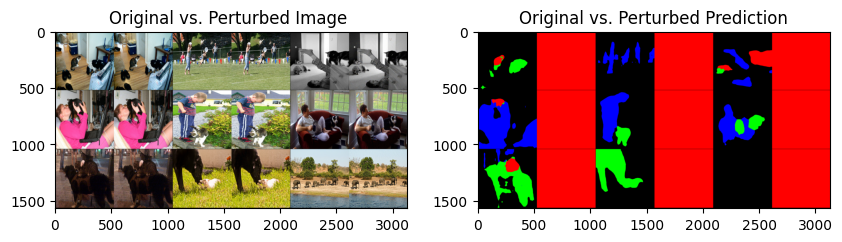

In [ ]:
# Visualisation des images à côté des images perturbées
plt.figure(figsize=(10, 5))
plt.subplot(1,  2, 1)
plt.title("Original vs. Perturbed Image ")
visu = torch.cat([img,perturbed_img],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())


# Visualisation des prédictions et des prédictions perturbées
plt.subplot(1, 2, 2)
plt.title("Original vs. Perturbed Prediction")
# Création de la prediction originale en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (outputs==1).float() # red for cat
pred[:,1,:,:] = (outputs==2).float() # green for dog
pred[:,2,:,:] = (outputs==3).float() # blue for person
# Création de la prediction perturbée en couleur
pred_pert = torch.zeros(9,3,520,520)
pred_pert[:,0,:,:] = (attacked_outputs==1).float() # red for cat
pred_pert[:,1,:,:] = (attacked_outputs==2).float() # green for dog
pred_pert[:,2,:,:] = (attacked_outputs==3).float() # blue for person
# Affichage
visu = torch.cat([pred,pred_pert],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())

plt.show()

Les résultats sont vraiment concluants, car on voit bien que l'attaque arrive à faire penser que l'entièreté de l'image est d'un même type.

Cela peut s'exploiter notamment en forçant le réseau à détecter uniquement du background, autrement dit, on peut faire en sorte que le réseau ne détecte jamais aucun objet en disant qu'il n'y a que du background.

# Evolution de la performance vis-à-vis de la norme autorisée de l'attaque

On peut ensuite se demander comment évolue la performance de la perturbation en fonction de la norme de l'attaque. Pour cela, on veut voir l'influence du ɛ qui permet de contenir l'attaque.

Nous allons tester cela avec plusieurs valeurs de ɛ plus ou moins grandes, afin de voir l'évolution de la cross entropy (lors de la dernière boucle d'apprentissage de l'attaque), en fonction de epsilon.

On choisit l'attaque targeted avec le même réseau.

In [52]:
W = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).eval()

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

with torch.no_grad():
  x = normalize(img)
  outputs = net(x)["out"] # on prédit des cartes de score de confiance
  outputs = outputs[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,outputs = outputs.max(1) # on prend le meilleur score

In [53]:
####### Mise en place de l'attaque #######
cefunction = torch.nn.CrossEntropyLoss()            # Fonction de perte, par exemple CrossEntropyLoss
attaque = torch.nn.Parameter(torch.zeros(x.shape))  # Créer la perturbation, initialement nulle
optimizer = torch.optim.SGD([attaque],lr=0.005)     # Optimiseur pour ajuster la perturbation

# Paramètres de l'attaque
epsilon = [1/510, 1/255, 5/255, 10/255, 20/255] # Amplitude maximale de la perturbation (invisibilité)
num_steps = 5                                       # Nombre d'itérations : On l'a réduit par rapport aux exemples précédents pour que ça soit plus rapide

# On initialise les grandeurs de sortie
ce_list = []                                      # On définit la liste des cross entropy
image_list = []                                   # On définit la liste des images perturbées

####### Optimisation de l'attaque #######
for eps in epsilon:
  # On réinitialise à chaque eps
  attaque = torch.nn.Parameter(torch.zeros(x.shape))
  optimizer = torch.optim.SGD([attaque],lr=0.005)
  # Même code que pour l'attaque targeted
  for i in range(num_steps):
    attacked_input = normalize(img + attaque)
    attacked_outputs = net(attacked_input)["out"]
    ce = cefunction(attacked_outputs, outputs)
    ce = -ce
    optimizer.zero_grad()
    ce.backward()
    attaque.grad = attaque.grad.sign()
    optimizer.step()
    with torch.no_grad():
      attaque = torch.clamp(attaque, -eps, eps) # Limiter la perturbation avec le eps qui varie
      attaque = torch.clamp(img + attaque, 0, 1) - img
    attaque = torch.nn.Parameter(attaque.clone())
    optimizer = torch.optim.SGD([attaque],lr=0.005)

  # On récupère la dernière valeur de la cross entropy à l'issue de l'optimisation de l'attaque
  print(eps,float(-ce))
  ce_list.append(float(-ce))

  # On récupère l'image qui nous intéresse
  perturbed_img = img + attaque
  image_list.append(perturbed_img[1].clone())


0.00196078431372549 3.690183639526367
0.00392156862745098 4.75909423828125
0.0196078431372549 7.18345308303833
0.0392156862745098 7.185595989227295
0.0784313725490196 7.185595989227295


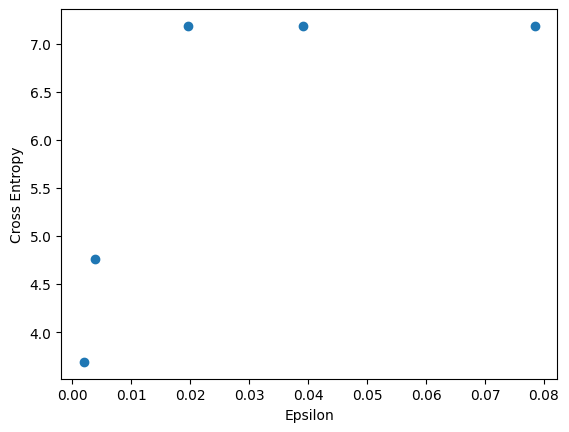

In [54]:
plt.plot(epsilon,ce_list, "o", label="Cross Entropy")
plt.xlabel("Epsilon")
plt.ylabel("Cross Entropy")
plt.show()

# # Visualisation des images à côté des images perturbées
# plt.title("Original vs. Perturbed Images")
# visu = torchvision.utils.make_grid(image_list,nrow=3)
# visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
# plt.imshow(visu.numpy())

# Comportement de notre attaque sur un autre réseau

Cette fois ci, on prend le même réseau que dans l'attaque untargeted, et nous allons voir comment se comporte cette attaque sur un autre réseau.

In [40]:
W = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).eval()

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

with torch.no_grad():
  x = normalize(img)
  outputs = net(x)["out"] # on prédit des cartes de score de confiance
  outputs = outputs[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,outputs = outputs.max(1) # on prend le meilleur score

In [41]:
####### Mise en place de l'attaque #######
cefunction = torch.nn.CrossEntropyLoss()            # Fonction de perte, par exemple CrossEntropyLoss
attaque = torch.nn.Parameter(torch.zeros(x.shape))  # Créer la perturbation, initialement nulle
optimizer = torch.optim.SGD([attaque],lr=0.005)     # Optimiseur pour ajuster la perturbation
epsilon = 10 / 255  # Amplitude maximale de la perturbation (invisibilité)
num_steps = 10      # Nombre d'itérations

####### Optimisation de l'attaque sur deeplabv3_mobilenet_v3_large #######
for i in range(num_steps):
  attacked_input = normalize(img + attaque)
  attacked_outputs = net(attacked_input)["out"]
  ce = cefunction(attacked_outputs, outputs)
  ce = -ce              # On veut Maximiser la cross entropy car on veut que le resultat perturbé soit le plus loin possible des résultats normaux
  optimizer.zero_grad()
  ce.backward()
  attaque.grad = attaque.grad.sign() # Gradient signé
  optimizer.step()
  with torch.no_grad():
    attaque = torch.clamp(attaque, -epsilon, epsilon) # Limiter la perturbation
    attaque = torch.clamp(img + attaque, 0, 1) - img  # Contrainte d'image valide
  attaque = torch.nn.Parameter(attaque.clone())
  optimizer = torch.optim.SGD([attaque],lr=0.005)

Une fois que l'on a entrainé notre modèle sur un réseau deeplabv3_mobilenet_v3_large, on essaye sur un autre type de réseau, ici on a choisit lraspp_mobilenet_v3_large mais on pourrait choisir tout autre réseau.

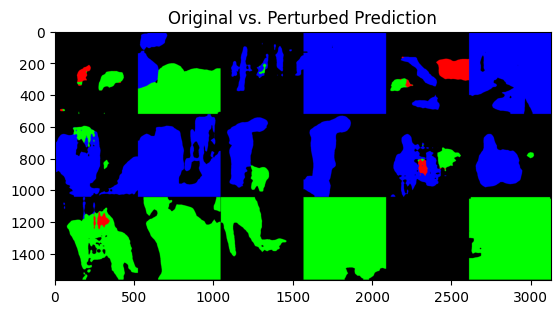

In [47]:
####### Test sur un deuxième réseau #######
W2 = torchvision.models.segmentation.LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net2 = torchvision.models.segmentation.lraspp_mobilenet_v3_large(weights=W2).eval()

# On récupère les prédictions initiales
with torch.no_grad():
  x = normalize(img)
  outputs2 = net2(x)["out"]
  outputs2 = outputs2[:,[0,8,12,15],:,:]
  _,outputs2 = outputs2.max(1)
# On récupère les prédictions obtenues après l'entrainement de l'attaque sur un autre réseau
with torch.no_grad():
    attacked_outputs2 = net(normalize(img+attaque))["out"]
    attacked_outputs2 = attacked_outputs2[:, [0, 8, 12, 15], :, :]
    _, attacked_outputs2 = attacked_outputs2.max(1)


# Visualisation des prédictions et des prédictions perturbées avec le deuxième réseau
plt.title("Original vs. Perturbed Prediction")
# Création de la prediction originale en couleur
pred2 = torch.zeros(9,3,520,520)
pred2[:,0,:,:] = (outputs2==1).float() # red for cat
pred2[:,1,:,:] = (outputs2==2).float() # green for dog
pred2[:,2,:,:] = (outputs2==3).float() # blue for person
# Création de la prediction perturbée en couleur
pred_pert2 = torch.zeros(9,3,520,520)
pred_pert2[:,0,:,:] = (attacked_outputs2==1).float() # red for cat
pred_pert2[:,1,:,:] = (attacked_outputs2==2).float() # green for dog
pred_pert2[:,2,:,:] = (attacked_outputs2==3).float() # blue for person
# Affichage
visu = torch.cat([pred2,pred_pert2],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())

plt.show()

On remarque que même sur un autre réseau, l'attaque marche plutôt bien, et arrive à brouiller correctement les prédictions du deuxième réseau.

On peut expliquer cela par deux choses :    
* Premièrement, les réseaux choisis sont des réseaux ayant une structure similaire, ce qui fait que l'attaque s'adapte mieux au deux réseaux.
* Ensuite, les deux réseaux sont entrainés sur les mêmes données, ce qui facilite le transfert de l'attaque de l'un à l'autre.

Il pourrait être intéressant de tester l'attaque, cette fois ci sur un type de réseau complètement différent pour voir si l'attaque est aussi facilement transferable.

# Apprentissage sur plusieurs réseaux

On a vu dans la partie précédente que l'attaque se transfère plutôt facilement sur des réseaux de même type et entrainés sur les mêmes données.

Il peut cependant être intéressant d'optimiser l'attaque sur un ensemble de réseau, afin de voir si l'apprentissage sur plusieurs réseaux est encore meilleur.

Pour cela, nous allons calculer la cross entropy pour chaque modèle, puis nous allons définir un critère à optimiser qui tient compte de toutes les cross entropy. Nous choisissons comme critère la moyenne des cross entropy car c'est un critère simple à mettre en oeuvre : On cherche $\text{max} (\frac{1}{n}\sum ce)$.



In [2]:
####### Choix des réseaux #######
# Premier réseau
W = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).eval()
# Deuxième réseau
W2 = torchvision.models.segmentation.LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net2 = torchvision.models.segmentation.lraspp_mobilenet_v3_large(weights=W2).eval()

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

####### Récup des résultats #######
with torch.no_grad():
  x = normalize(img)
  outputs = net(x)["out"] # on prédit des cartes de score de confiance
  outputs = outputs[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,outputs = outputs.max(1) # on prend le meilleur score

with torch.no_grad():
  x = normalize(img)
  outputs2 = net(x)["out"] # on prédit des cartes de score de confiance
  outputs2 = outputs2[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,outputs2 = outputs2.max(1) # on prend le meilleur score

In [3]:
####### Mise en place de l'attaque #######
cefunction = torch.nn.CrossEntropyLoss()            # Fonction de perte, par exemple CrossEntropyLoss
attaque = torch.nn.Parameter(torch.zeros(x.shape))  # Créer la perturbation, initialement nulle
optimizer = torch.optim.SGD([attaque],lr=0.005)     # Optimiseur pour ajuster la perturbation

# Paramètres de l'attaque
epsilon = 10 / 255  # Amplitude maximale de la perturbation
num_steps = 10      # Nombre d'itérations

####### Optimisation de l'attaque #######
for i in range(num_steps):
  # Calculer les prédictions avec perturbation
  attacked_input = normalize(img + attaque)
  attacked_outputs = net(attacked_input)["out"]
  attacked_outputs2 = net2(attacked_input)["out"]

  # Calculer la cross entropy et l'afficher
  # La cross entropy est la mesure qui dit à quel point les deux arguments sont différents
  ce = cefunction(attacked_outputs, outputs)
  ce2 = cefunction(attacked_outputs2, outputs2)
  total_loss = (ce + ce2)/2
  print(i,float(total_loss))

  # Calculer les gradients par rapport à la perturbation
  total_loss = -total_loss              # On veut Maximiser la cross entropy car on veut que le resultat perturbé soit le plus loin possible des résultats normaux
  optimizer.zero_grad()
  total_loss.backward()
  attaque.grad = attaque.grad.sign() # Gradient signé
  optimizer.step()

  # Mettre à jour la perturbation
  with torch.no_grad():
    attaque = torch.clamp(attaque, -epsilon, epsilon) # Limiter la perturbation
    attaque = torch.clamp(img + attaque, 0, 1) - img  # Contrainte d'image valide

  # Optimisation de l'attaque
  attaque = torch.nn.Parameter(attaque.clone())
  optimizer = torch.optim.SGD([attaque],lr=0.005)


####### Récupérer les résultats de l'attaque #######
# Appliquer la perturbation à l'image originale
perturbed_img = img + attaque

# Prédictions après attaque
with torch.no_grad():
    attacked_outputs = net(normalize(perturbed_img))["out"]
    attacked_outputs = attacked_outputs[:, [0, 8, 12, 15], :, :]
    _, attacked_outputs = attacked_outputs.max(1)

with torch.no_grad():
    attacked_outputs2 = net2(normalize(perturbed_img))["out"]
    attacked_outputs2 = attacked_outputs2[:, [0, 8, 12, 15], :, :]
    _, attacked_outputs2 = attacked_outputs2.max(1)

0 2.4947056770324707
1 4.030494213104248
2 5.252416610717773
3 6.112631797790527
4 7.418910980224609
5 8.574390411376953
6 9.90565299987793
7 10.798004150390625
8 12.33637809753418
9 13.850491523742676


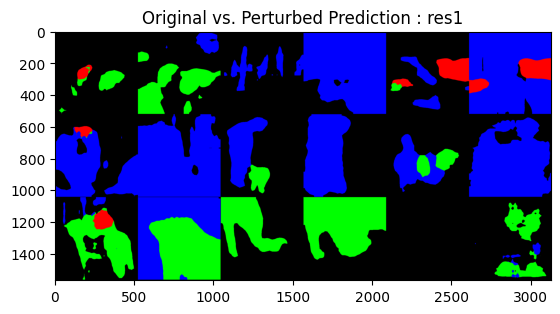

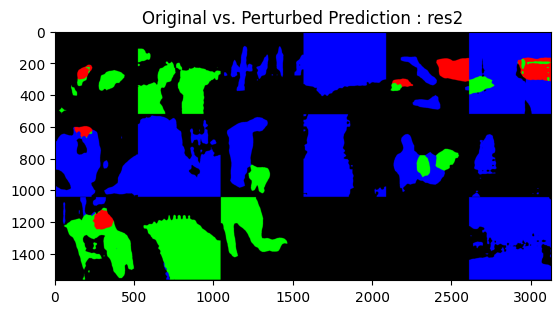

In [5]:
# Visualisation des prédictions et des prédictions perturbées avec le deuxième réseau
plt.title("Original vs. Perturbed Prediction : res1")
# Création de la prediction originale en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (outputs==1).float() # red for cat
pred[:,1,:,:] = (outputs==2).float() # green for dog
pred[:,2,:,:] = (outputs==3).float() # blue for person
# Création de la prediction perturbée en couleur
pred_pert = torch.zeros(9,3,520,520)
pred_pert[:,0,:,:] = (attacked_outputs==1).float() # red for cat
pred_pert[:,1,:,:] = (attacked_outputs==2).float() # green for dog
pred_pert[:,2,:,:] = (attacked_outputs==3).float() # blue for person
# Affichage
visu = torch.cat([pred,pred_pert],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())

plt.show()

# Visualisation des prédictions et des prédictions perturbées avec le deuxième réseau
plt.title("Original vs. Perturbed Prediction : res2")
# Création de la prediction originale en couleur
pred2 = torch.zeros(9,3,520,520)
pred2[:,0,:,:] = (outputs2==1).float() # red for cat
pred2[:,1,:,:] = (outputs2==2).float() # green for dog
pred2[:,2,:,:] = (outputs2==3).float() # blue for person
# Création de la prediction perturbée en couleur
pred_pert2 = torch.zeros(9,3,520,520)
pred_pert2[:,0,:,:] = (attacked_outputs2==1).float() # red for cat
pred_pert2[:,1,:,:] = (attacked_outputs2==2).float() # green for dog
pred_pert2[:,2,:,:] = (attacked_outputs2==3).float() # blue for person
# Affichage
visu = torch.cat([pred2,pred_pert2],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())

plt.show()

On remarque que les prédictions initiales des deux réseaux sont très similaires. Cependant, si on compare les prédictions avec l'attaque, on remarque que sur certaines images, les prédictions sont plutôt similaires, alors que sur d'autres, les prédictions attaquées sont très différentes.

Malgré cela, on voit bien que l'attaque marche très bien avec les deux réseaux. Et comme au test précédent, il faudrait essayer de mener la même expérience avec deux réseaux plus différents pour voir si l'apprentissage de l'attaque sur deux réseaux améliore vraiment la qualité de l'attaque.